In [1]:
import os
import json
import sys
sys.path.append("../")
from data.feature_loader import get_feature_loader
from utils.summary import generate_summary, evaluate_summary
from deployment.io import read_frames

import json
import numpy as np
from collections import OrderedDict
# from src.evaluation.summary_loader import load_processed_dataset
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import altair as alt
import json
import numpy as np
from collections import OrderedDict
# from src.evaluation.summary_loader import load_processed_dataset
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import altair as alt
import random

In [2]:

score_dir = "/your/score/dir"
def load_scores_dir(scores_dir):
    scores = {}
    for split_file in os.listdir(scores_dir):
        if split_file.endswith("json"):
            with open(os.path.join(scores_dir, split_file)) as fp:
                split_scores = json.load(fp)
                for video_key in split_scores:
                    scores[video_key] = split_scores[video_key]
    return scores


scores = load_scores_dir(score_dir)

In [22]:
class DatasetEvaluator():
    def __init__(self, video_dir, mappings, feature_dict):
        self.video_dir = video_dir
        self.mappings = mappings
        self.feature_dict = feature_dict
        
    def find_video_name(self, video_key):
        r = list(filter(lambda x:x['h5_key'] == video_key, self.mappings))
        return r[0]['name']
    
    def analyze_video(self, video_key, scores):
        batch = self.feature_dict[video_key]
        image_features, video_names, change_points, num_frames, nfps, positions, user_summary = batch[:7]
        change_points = change_points[0].numpy()
        num_frames = num_frames[0]
        nfps = nfps
        length = 0
        for nfp in nfps:
            length = length + nfp.item()
        nfps = list(map(lambda x: int(x[0]), nfps))
        positions = positions[0]
        user_summary = user_summary[0].numpy()
        positions = positions.view(-1).numpy()
        machine_summary = generate_summary(scores, change_points, num_frames, nfps, positions)
        fm = evaluate_summary(machine_summary, user_summary, "avg")
        video_name = self.find_video_name(video_key)
        video_path = os.path.join(video_dir, video_name)
        video_length, _, _, _ = read_video_meta(video_path)
#         print(video_key, video_length, video_name, fm)
        return video_length, video_name, fm
    
    def extract_gt_score_df(self, batch):
        video_df = pd.DataFrame(columns=["frame", "score"])
        gt_scores = batch[7].squeeze().detach().tolist()
        for idx, score in  enumerate(gt_scores):
            d = pd.Series({'frame': idx, 'score': gt_scores[idx]})
            video_df = video_df.append(d, ignore_index=True)
        return video_df


    def extract_gt_scores(self, batch):
        gt_scores = batch[7].squeeze().detach().tolist()
        return gt_scores

    def extract_summary(self, scores, batch):
        image_features, video_names, change_points, num_frames, nfps, positions, user_summary = batch[:7]
        change_points = change_points[0].numpy()
        num_frames = num_frames[0]
    #     print(num_frames)
        nfps = nfps
    #     print(nfps)
        length = 0
        for nfp in nfps:
            length = length + nfp.item()
        nfps = list(map(lambda x: int(x[0]), nfps))
        positions = positions[0]
        user_summary = user_summary[0].numpy()
        positions = positions.view(-1).numpy()
        machine_summary = generate_summary(scores, change_points, num_frames, nfps, positions)
        seg_summary = []
        for i in range(len(positions) - 1):
            pos_left, pos_right = positions[i], positions[i+1]
            seg_summary.append(machine_summary[pos_left])
        seg_summary.append(machine_summary[pos_right])
        return seg_summary

    def plot_summary(self, score_df, summary, show_label=False):
        summary_frames = []
        for idx, selected in enumerate(summary):
            if selected:
                summary_frames.append(idx)
        summary_df = score_df[score_df['frame'].isin(summary_frames)]
        score_df['summary'] = "original"
        score_df.loc[score_df['frame'].isin(summary_frames),'summary'] =  "summary"
        score_max = score_df['score'].max()
        score_min = score_df['score'].min()
        domain_left = score_min - (score_max - score_min) * 0.2
        domain_right = score_max + (score_max - score_min) * 0.2
        score_df['score'] = score_df['score'] - domain_left
        all_frames_plot =  alt.Chart(score_df).mark_bar().encode(
            alt.X('frame'
            ),
            y='score'
        )

        summary_frames_plot = alt.Chart(score_df).mark_bar().encode(
            alt.X('frame:O',axis=alt.Axis(labels=show_label, title="")),
            alt.Y("score:Q", axis=alt.Axis(labels=False, title="")),
            color=alt.Color("summary:N", legend=None),
            opacity=alt.Opacity("summary:N", legend=None)
        ).configure_axis(
            grid=False
        ).properties(
            width=1000,
            height=200
        ).interactive()

        return  summary_frames_plot
    
    def produce_summary_plot(self, video_key, scores, show_labels=False):
        batch = self.feature_dict[video_key]
        summary = self.extract_summary(scores, batch)
        score_df = self.extract_gt_score_df(batch)
        return self.plot_summary(score_df, summary, show_labels)

    def produce_gt_summary_plot(self, video_key, show_labels=False):
        batch = self.feature_dict[video_key]
        gt_scores = self.extract_gt_scores(batch)
        return self.produce_summary_plot(video_key, gt_scores, show_labels)
    
    def show_mappings(self):
        for item in self.mappings:
            print(item)
    
    def visualize_segments(self, video_key, frame_range, n_picks = 5):
        range_length = frame_range[1] - frame_range[0]
        interval = range_length // 5
        picks = []
        for i in range(n_picks):
            picks.append(frame_range[0] + i * interval)
        video_name = self.find_video_name(video_key)
        video_path = os.path.join(self.video_dir, video_name)
        frames = read_frames(video_path, picks)
        frame_height = frames[0].shape[0]
        frame_width = frames[0].shape[1]
        montage = np.zeros((frame_height,frame_width * n_picks ,3), np.uint8)
        for i, frame in enumerate(frames):
            montage[:, i * frame_width : (i+1)*frame_width,:] = frame
        return montage
    
    def produce_summary_frames(self, summary, video_key, n_picks=6):
        summary_frames = []
        for idx, selected in enumerate(summary):
            if selected:
                summary_frames.append(idx)
        picks = []
        sample_len = len(summary_frames) // n_picks
        for i in range(n_picks):
            picks.append(summary_frames[i * sample_len + random.randint(0, sample_len - 1)])
        video_name = self.find_video_name(video_key)
        video_path = os.path.join(self.video_dir, video_name )
        picks = list(map(lambda x: x*15, picks))
        return read_frames(video_path, picks)

    
    def merge_frames(self, frames):
        n_frames = len(frames)
        frame_height = frames[0].shape[0]
        frame_width = frames[0].shape[1]
        montage = np.zeros((frame_height,frame_width * n_frames ,3), np.uint8)
        for i, frame in enumerate(frames):
            montage[:, i * frame_width : (i+1)*frame_width,:] = frame
        plt.imshow(montage)
        return montage

    
    def produce_summary_montage(self, video_key, scores):
        batch = self.feature_dict[video_key]
        summary = self.extract_summary(scores, batch)
        frames = self.produce_summary_frames(summary, video_key)
        montage = self.merge_frames(frames)
    
def build_feature_dict(data_loader):
    feature_dict = {}
    for batch in data_loader:
        image_features, video_names, change_points, num_frames, nfps, positions, user_summary = batch[:7]
        video_key = batch[-2][0]
    #     print(video_key)
        change_points = change_points[0].numpy()
        num_frames = num_frames[0]
        nfps = nfps
        nfps = list(map(lambda x: int(x[0]), nfps))
        positions = positions[0]
        user_summary = user_summary[0].numpy()
        positions = positions.view(-1).numpy()
        feature_dict[video_key] = batch
    return feature_dict

def build_dataset_evaluator(video_dir="", mapping_path="", h5_path=""):
    with open(mapping_path) as fp:
        mappings = json.load(fp)
    video_keys = list(map(lambda x: x['h5_key'], mappings))
    data_loader = get_feature_loader(h5_path, video_list=video_keys, with_images=False)
    feature_dict = build_feature_dict(data_loader)
    evaluator = DatasetEvaluator(video_dir, mappings, feature_dict)
    return evaluator


In [23]:
tvsum_video_dir="/your/video/dir"
tvsum_mapping_path="../data/mappings/tvsum_mapping.json" 
tvsum_h5_path="/your/h5/path"
tvsum_evaluator = build_dataset_evaluator(tvsum_video_dir, tvsum_mapping_path, tvsum_h5_path)


In [26]:
# Our method result
video_key = "video_42"
video_score = scores[video_key]
tvsum_evaluator.produce_summary_plot(video_key, video_score)


alt.Chart(...)

In [27]:
# Summary generated by the ground-truth scores
tvsum_evaluator.produce_gt_summary_plot(video_key)

alt.Chart(...)

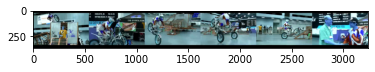

In [25]:
# Show a montage
tvsum_evaluator.produce_summary_montage(video_key, video_score)